# Education and Health Prediction

The goal of this project is to apply the skills that I have been developing in the last two years learning bioinformatics and computer science to explore a topic that I am interested in: the affects of education on the outcomes of health. 

The main objective is to create a predictive model that will include educational features in order to estimate the DALY (disability-adjusted lost years gathered through the IHME) for different countries and its relationship with the HDI (human developmental index, education rating).

One of the skills that I want to improve the most through this project is the ability to conduct my own data analysis independently without the assistance from others. Working in a research lab, I have been supervised by a PhD student and wanted to be able to produce my own work without constant assistance.

In [1]:
# This project was created with the table of contents from the jupyer nbextensions installed for easy access

from math import sqrt, e
import matplotlib.pyplot as plt #Plotting data
import matplotlib.patches as mpatches #Making custom legends for figures
import numpy as np #Math functions and arrays
import pandas as pd #Data tables 
import seaborn as sns #Extra plotting functions with better style

from   scipy.stats import linregress,norm,ttest_ind,zscore #Useful for extracting stats info
import statistics #Statistics
import statsmodels.api as sm #More stats functions

#Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA #PCA
from sklearn.cluster import KMeans #Clustering
from sklearn.metrics import mean_squared_error, r2_score #RMSE and r2
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures
import operator

# Human Development Index - Education Rating (2010 : 2018)
HDI = pd.read_csv('Education Index.csv')

# Disability-Adjusted Lost Years
DALY = pd.read_csv('DALY.csv')

# GINI Coefficient
GINI = pd.read_csv('GINI Index.csv')

# Shared locations
locations = set(HDI['location'].values) & set(DALY['location'].unique())

## Exploring and cleaning the dataset

Simple exploration of the dataset that I am interested in: how DALY is affected by the education of a country while controlling for economic inequality. Show the distribution of the data to see what kind of dataset that I am working with.

DALY mean, median, std: 34182.92, 30820.47, 12252.26
HDI  mean, median, std: 0.65, 0.68, 0.17
GINI mean, median, std: 37.33, 35.9, 7.7


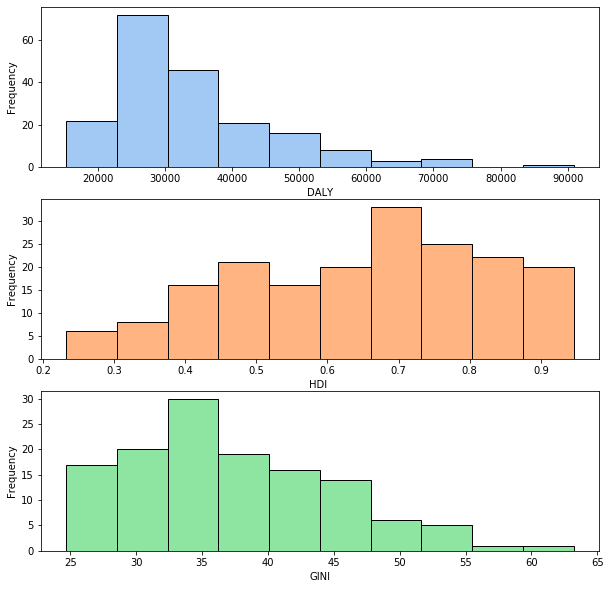

In [13]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
i = 0
c = sns.color_palette('pastel')
labels = ['DALY','HDI ','GINI']
for df in [DALY[DALY['metric'] == 'average']['2016'].values,HDI['2016'].values,GINI['average'].values]:
    mean  = round(df.mean(),2)
    med   = round(statistics.median(df),2)
    std   = round(df.std(),2)
    ax[i].hist(df,color=c[i],edgecolor='black')
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel('Frequency')
    print(str(labels[i]), 'mean, median, std: %s, %s, %s' % (mean,med,std))
    i += 1

Linear model:     R^2   :  0.3399  RMSE  :  10072.3139
Polynomial model: R^2   :  0.4538  RMSE  :  9162.0


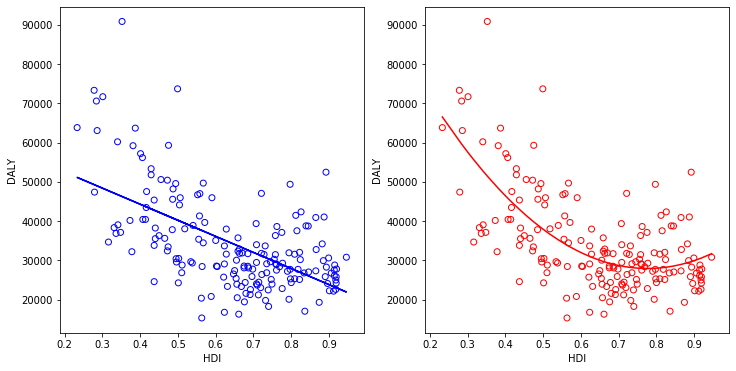

In [14]:
# Simple regression model just using HDI vs DALY
x = HDI[HDI['location'].isin(locations)]['2016'].values
y = DALY[(DALY['metric'] == 'average') & (DALY['location'].isin(locations))]['2016'].values

slope, intercept, rvalue, pvalue, stderr = linregress(x,y)

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(x,y,facecolors='none', edgecolors='b')
y_pred = intercept + (slope * x)
ax[0].plot(x,y_pred,label='Fitted line', color='b')

ax[0].set_xlabel('HDI')
ax[0].set_ylabel('DALY')

rmse = sqrt(mean_squared_error(y, y_pred))
print('Linear model:     R^2   : ', round(rvalue**2,4), ' RMSE  : ', round(rmse,4))

x = HDI[HDI['location'].isin(locations)]['2016'].values.reshape(-1,1)
y = DALY[(DALY['metric'] == 'average') & (DALY['location'].isin(locations))]['2016'].values.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_pred))
r2 = r2_score(y,y_pred)

ax[1].scatter(x,y,facecolors='none', edgecolors='r')
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_pred), key=sort_axis)
x, y_pred = zip(*sorted_zip)
ax[1].plot(x, y_pred, color='r')

ax[1].set_xlabel('HDI')
ax[1].set_ylabel('DALY')

print('Polynomial model: r2   : ', round(r2,4), ' RMSE  : ', round(rmse))

## Confounding variable: economic disparity

For this relationship, I want to control for economical factors. Since wealthier countries will have more resources to contribute to a more educated and healthier population, the factor that I have chosed instead is the GINI coefficient. The GINI coefficient is the statistical measurement for the disparity between the wealthiest and the poorest individual within the population.

In [15]:
GINI_df = GINI[GINI['location'].isin(locations)].copy()
GINI_locations = GINI_df.sort_values('average')['location'].values

low_HDI  = HDI[HDI['location'].isin(GINI_locations[0:int(len(GINI_locations)/2)])]['2016'].values
low_DALY = DALY[(DALY['metric'] == 'average') 
                & DALY['location'].isin(GINI_locations[0:int(len(GINI_df)/2)])]['2016'].values

high_HDI  = HDI[HDI['location'].isin(GINI_locations[int(len(GINI_locations)/2):int(len(GINI_locations))])]['2016'].values
high_DALY = DALY[(DALY['metric'] == 'average') 
                 & (DALY['location'].isin(GINI_locations[int(len(GINI_locations)/2):int(len(GINI_locations))]))]['2016'].values

print('HDI difference:')
print(ttest_ind(low_HDI,high_HDI,equal_var=False))
print(round(abs(((high_HDI.mean() - low_HDI.mean()) / ((high_HDI.mean() + low_HDI.mean())/2)) * 100),2))

print('DALY difference:')
print(ttest_ind(low_DALY,high_DALY,equal_var=False))
print(round(abs(((high_DALY.mean() - low_DALY.mean()) / ((high_DALY.mean() + low_DALY.mean())/2)) * 100),2))

HDI difference:
Ttest_indResult(statistic=4.472119776566463, pvalue=1.7883282463721092e-05)
20.97
DALY difference:
Ttest_indResult(statistic=-1.68597315596708, pvalue=0.09440528169383353)
9.86


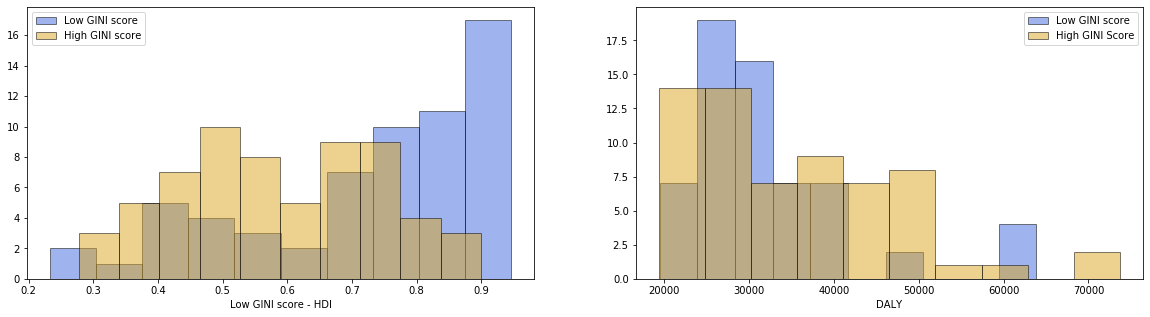

In [16]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].hist(low_HDI,alpha=0.5,color='royalblue',edgecolor='black',label='Low GINI score')
ax[0].hist(high_HDI,alpha=0.5,color='goldenrod',edgecolor='black',label='High GINI score')
ax[0].set_xlabel('Low GINI score - HDI')
ax[0].legend()

ax[1].hist(low_DALY,alpha=0.5,color='royalblue',edgecolor='black',label='Low GINI score')
ax[1].hist(high_DALY,alpha=0.5,color='goldenrod',edgecolor='black',label='High GINI Score')
ax[1].set_xlabel('DALY')
ax[1].legend()

Low GINI score:      R^2:  0.5   RMSE:  7108.96
high GINI score:     R^2:  0.32  RMSE:  9934.92


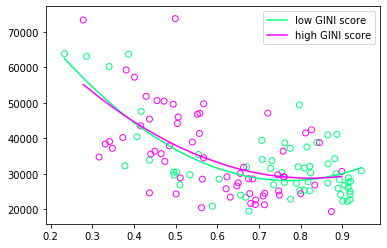

In [17]:
low_HDI = low_HDI.reshape(-1,1)
low_DALY = low_DALY.reshape(-1,1)

polynomial_features = PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(low_HDI)

model = LinearRegression()
model.fit(x_poly, low_DALY)
y_pred = model.predict(x_poly)

rmse = sqrt(mean_squared_error(low_DALY, y_pred))
r2 = r2_score(low_DALY,y_pred)
print('Low GINI score:      r^2: ', round(r2,2), '  RMSE: ', round(rmse,2))

plt.scatter(low_HDI,low_DALY,facecolors='none',edgecolors='springgreen')
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(low_HDI,y_pred), key=sort_axis)
x, y_pred = zip(*sorted_zip)
plt.plot(x,y_pred,color='springgreen',label='low GINI score')
########################################################################################################################
high_HDI = high_HDI.reshape(-1,1)
high_DALY = high_DALY.reshape(-1,1)

x_poly = polynomial_features.fit_transform(high_HDI)
model.fit(x_poly, high_DALY)
y_pred = model.predict(x_poly)

rmse = sqrt(mean_squared_error(high_DALY, y_pred))
r2 = r2_score(high_DALY,y_pred)
print('high GINI score:     r^2: ', round(r2,2), ' RMSE: ', round(rmse,2))

plt.scatter(high_HDI,high_DALY,facecolors='none',edgecolors='fuchsia')
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(high_HDI,y_pred), key=sort_axis)
x, y_pred = zip(*sorted_zip)
plt.plot(x,y_pred,color='fuchsia',label='high GINI score')

plt.legend()

As shown in the data above, when controlled for the GINI coefficient, there is a significant difference between the two populations' education rating but unable to show that there is a difference between the DALY. This suggests that Countries with low disparity tend to score on average a higher HDI score by 21%. Moving forward, the model will be used to predict the education rating of a given country based on features as a proxy for DALY.

## Feature engineering for education index (HDI)

Because data becomes very limiting and cannot be generalized easily, I will be using the data within the United States to predict its education rating as country-wide data on specific features will be difficult to locate.

Create a multiple linear regression model using data collected from the US, and attempt to see if the model can be translated using country data.

In [65]:
US_df = pd.read_csv('US.csv')
US_df = US_df.drop(8).reset_index().drop(columns='index') # Removes District of Coloumbia
US_df

,state,education index,GINI score,median household income,median family income,cost index,average household size,single-parent household,primary class size,secondary class size,post-secondary education,average teacher salary,spendings per student,teen pregnancy
0,Louisiana,0.863,0.4990,44555,56573,93.9,2.61,11.67,19.0,23.4,20.89,40303,11038,13.1
1,Mississippi,0.854,0.4828,39680,50178,86.1,2.62,11.30,21.6,22.8,21.79,34784,8702,22.5
2,New Mexico,0.874,0.4769,44803,54705,87.5,2.64,9.69,19.8,23.7,24.41,36405,9693,12.5
3,North Carolina,0.887,0.4780,46556,57380,94.9,2.52,9.53,18.8,25.8,24.15,37631,8792,16.2
4,Georgia,0.886,0.4813,49321,58885,89.2,2.71,9.51,21.0,27.5,27.49,35474,9769,19.1
5,South Carolina,0.880,0.4735,45238,56491,95.9,2.54,8.94,19.1,26.0,23.57,33148,10249,22.6
6,Oklahoma,0.884,0.4645,47529,58710,87.0,2.58,8.63,20.7,23.7,21.64,32010,8097,15.0
7,Rhode Island,0.890,0.4781,54891,71212,119.4,2.47,8.28,NaN,NaN,28.89,41689,15532,21.7
8,Delaware,0.901,0.4522,59716,72594,108.1,2.58,8.07,20.3,25.8,25.41,41639,14713,18.5
9,Arkansas,0.862,0.4719,41262,51528,86.9,2.52,8.00,20.4,25.4,17.57,33323,9846,32.8


GINI score: r2 - 0.0633  pvalue -  0.07800837627968916
median household income: r2 - 0.579  pvalue -  1.427073889661926e-10
median family income: r2 - 0.6335  pvalue -  4.896814222972009e-12
cost index: r2 - 0.1922  pvalue -  0.001451392329418995
average household size: r2 - 0.029  pvalue -  0.23745042084459825
single-parent household: r2 - 0.3298  pvalue -  1.296363611817946e-05
primary class size: r2 - 0.0051  pvalue -  0.6417649681503383
secondary class size: r2 - 0.052  pvalue -  0.13178241852839823
post-secondary education: r2 - 0.6306  pvalue -  5.9637340721458254e-12
average teacher salary: r2 - 0.1679  pvalue -  0.0031224560237842697
spendings per student: r2 - 0.2126  pvalue -  0.0007512764088106124
teen pregnancy: r2 - 0.0589  pvalue -  0.08960617920638814


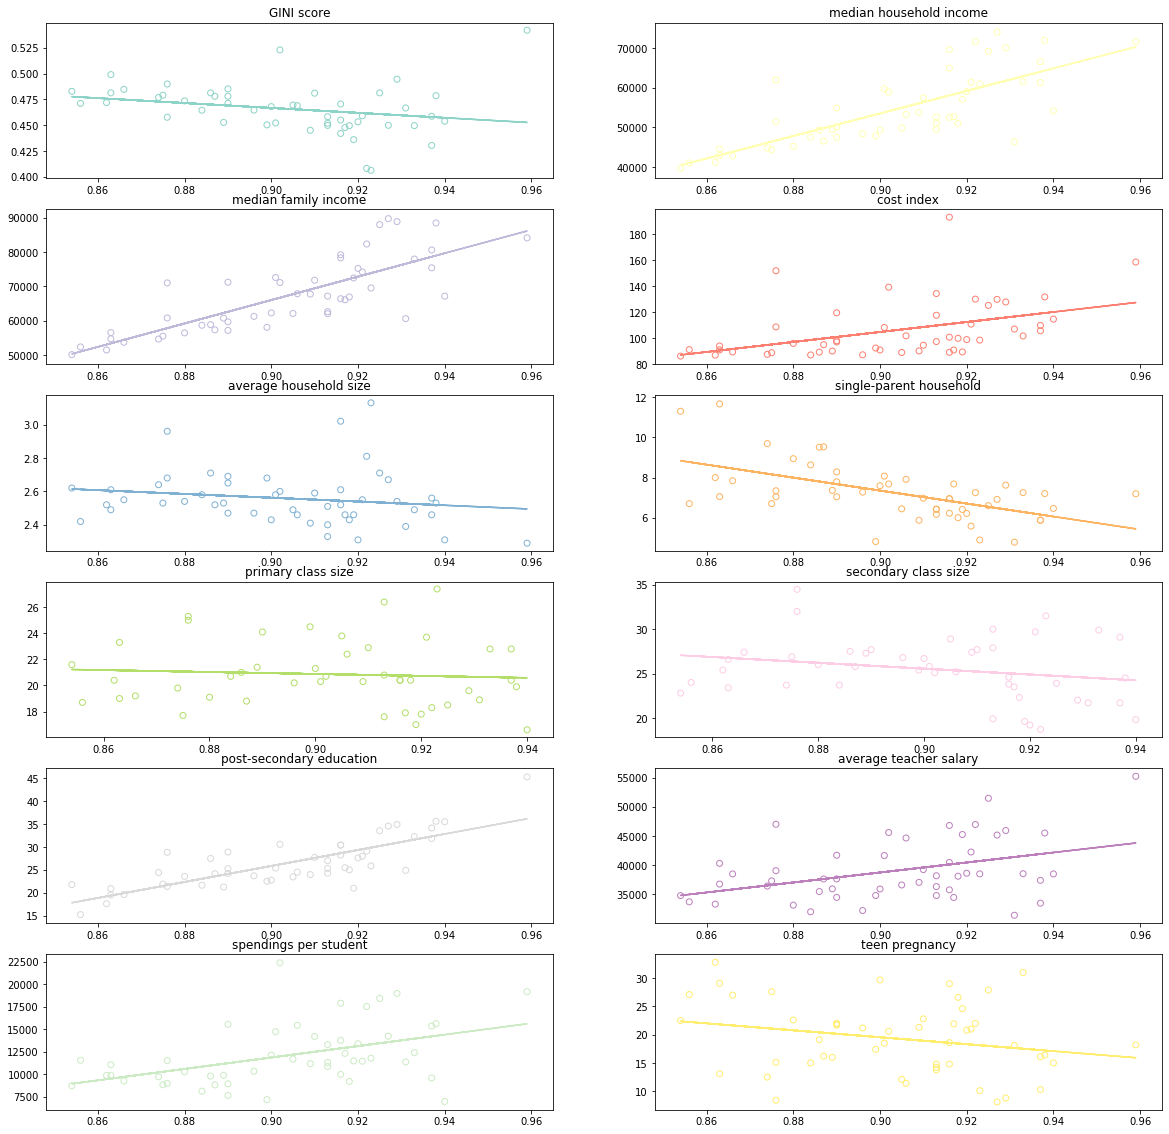

In [66]:
feats = ['GINI score', 'median household income','median family income', 'cost index', 
         'average household size', 'single-parent household',
           'primary class size', 'secondary class size', 'post-secondary education','average teacher salary',
         'education spending', 'teen pregnancy']
fig, ax = plt.subplots(6,2,figsize=(20,20))
c = sns.color_palette('Set3')
i = 0
j = 0

features = {'feature' : [], 'r2' : [], 'pvalue' : []}
for feat in feats:
    x = US_df.iloc[US_df[feat].dropna().index]['education index'].values
    y = US_df[feat].dropna()
    slope, intercept, rvalue, pvalue, stderr = linregress(x,y)
    y_pred = intercept + (slope * x)
    ax[i,j].plot(x,y_pred, color=c[i * 2 + j])
    ax[i,j].scatter(x,y,facecolors='none', edgecolors=c[i * 2 + j])
    ax[i,j].set_title(feat)
    
    if (j % 2 == 0):
        j = 1
    else:
        i += 1
        j = 0
    print(feat+':','r2 -', round(rvalue**2,4), ' pvalue - ', pvalue)
    features['feature'].append(feat)
    features['r2'].append(round(rvalue**2,4))
    features['pvalue'].append(pvalue)

In [69]:
feats_df = pd.DataFrame(features).sort_values('pvalue', ascending=True)
feats_df.head(8)['feature'].values

array(['median family income', 'post-secondary education',
       'median household income', 'single-parent household',
       'spendings per student', 'cost index', 'average teacher salary',
       'GINI score'], dtype=object)

# Education Regression Model

## Creating a model using data collected from the US

In [3]:
US_df = pd.read_csv('US.csv')
US_df = US_df.drop(8).reset_index().drop(columns='index') # Removes District of Coloumbia
features = ['post-secondary education', 'median household income', 
            'single-parent household', 'education spending', 
            'cost index', 'teacher salary', 'GINI score']
US_df[features].head(5)

,post-secondary education,median household income,single-parent household,education spending,cost index,teacher salary,GINI score
0,19.60,42830,7.84,3.39,89.3,38491,0.4847
1,29.10,71583,7.25,4.69,129.9,46954,0.4081
2,25.25,50068,7.04,2.75,97.0,34473,0.4713
3,17.57,41262,8.00,4.06,86.9,33323,0.4719
4,28.84,61933,7.34,2.70,151.7,46992,0.4899


r2: 0.8561 rmse 0.0 difference 0.007624224998505808


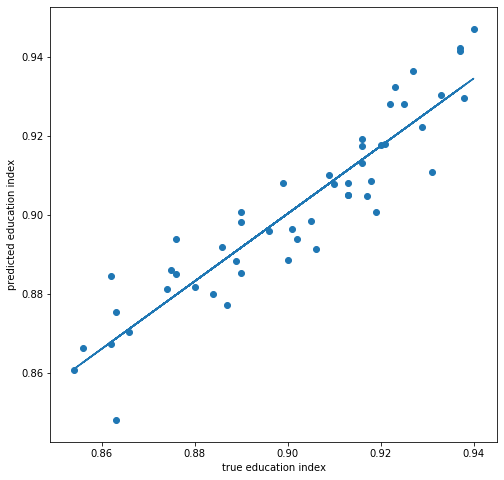

In [4]:
model = LinearRegression()
model.fit(US_df[features], US_df['education index'])

model_df = pd.DataFrame(columns=['state','true','predicted','difference'])
model_df['state'] = US_df['state']
model_df['true'] = US_df['education index']
model_df['predicted'] = model.predict(US_df[features])
model_df['difference'] = abs(model_df['true'] - model_df['predicted'])

slope, intercept, rvalue, pvalue, stderr = linregress(model_df['true'], model_df['predicted'])
y_pred = intercept + (slope * model_df['true'])
rmse = np.sqrt(mean_squared_error(model_df['true'],y_pred))

plt.figure(figsize=(8,8))
plt.plot(model_df['true'],y_pred)
plt.scatter(model_df['true'], model_df['predicted'])
plt.xlabel('true education index')
plt.ylabel('predicted education index')

print('r2:', round(rvalue**2,4), 'rmse', round(rmse), 'difference', model_df['difference'].mean())

In [6]:
model_df.sort_values('difference',ascending=False).head(5)

,state,true,predicted,difference
42,Texas,0.862,0.884374,0.022374
25,Montana,0.931,0.910906,0.020094
49,Wyoming,0.919,0.900526,0.018474
4,California,0.876,0.893895,0.017895
17,Louisiana,0.863,0.848014,0.014986


In [7]:
coefs = pd.DataFrame()
coefs['features'] = features
coefs['coefficeients'] = model.coef_
coefs

,features,coefficeients
0,post-secondary education,3.776729e-03
1,median household income,9.602723e-08
2,single-parent household,-5.847658e-03
3,education spending,2.039059e-03
4,cost index,-2.008313e-04
5,teacher salary,-6.524915e-08
6,GINI score,-2.838806e-01


## Employing the model using data collected from different countries

In [2]:
US_df = pd.read_csv('US.csv')
US_df = US_df.drop(8).reset_index().drop(columns='index') # Removes District of Coloumbia
features = ['post-secondary education', 'median household income', 
            'single-parent household', 'education spending', 
            'cost index', 'teacher salary', 'GINI score']

In [4]:
df = pd.read_csv('Country.csv')
df = df.dropna(thresh=df.shape[1]-2)
for col in df.columns:
    value = df.iloc[0][col]
    df[col] = df[col].fillna(value)
df[features].head(5)

,post-secondary education,median household income,single-parent household,education spending,cost index,teacher salary,GINI score
0,24.46,13219.0,6.03,4.5,51.30,46392.23,0.3733
2,12.40,7314.0,6.03,4.0,36.63,46392.23,0.2900
7,21.44,14432.0,6.03,5.5,38.72,46392.23,0.4190
8,48.32,3865.0,6.03,2.7,32.70,46392.23,0.3090
10,53.00,46555.0,6.03,5.3,73.39,59568.04,0.3470


In [9]:
US_df[features].head(5)

,post-secondary education,median household income,single-parent household,education spending,cost index,teacher salary,GINI score
0,19.60,42830,7.84,3.39,89.3,38491,0.4847
1,29.10,71583,7.25,4.69,129.9,46954,0.4081
2,25.25,50068,7.04,2.75,97.0,34473,0.4713
3,17.57,41262,8.00,4.06,86.9,33323,0.4719
4,28.84,61933,7.34,2.70,151.7,46992,0.4899


         location   true  predicted  transformation  difference
150        Rwanda  0.453   0.819062        0.371035   19.893568
166  South Africa  0.721   0.827410        0.596563   18.889040
72      Guatemala  0.511   0.843549        0.431054   16.972748
77       Honduras  0.503   0.843630        0.424346   16.963316
177      Tanzania  0.417   0.850424        0.354627   16.166731
r2: 0.9654 rmse 0.0426 difference 7.700316238793662


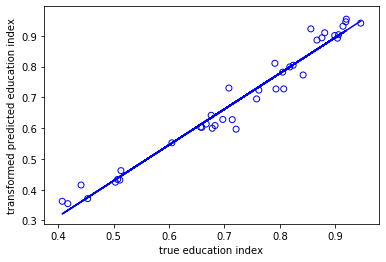

In [11]:
model = LinearRegression()
model.fit(US_df[features], US_df['education index'])
train_data, test_data = train_test_split(df, test_size=0.5)

model_df = pd.DataFrame(columns=['location','true','predicted','transformation', 'difference'])
model_df['location'] = train_data['location']
model_df['true'] = train_data['education index']
model_df['predicted'] = model.predict(train_data[features])
model_df['transformation'] = model_df['predicted'] * model_df['true']

model_df['difference'] = 100 * (abs(model_df['true'] - model_df['transformation']) / ((model_df['true'] + model_df['transformation']) / 2))

slope, intercept, rvalue, pvalue, stderr = linregress(model_df['true'], model_df['transformation'])
y_pred = intercept + (slope * model_df['true'])
rmse = np.sqrt(mean_squared_error(model_df['true'],y_pred))

plt.plot(model_df['true'],y_pred,color='b')
plt.scatter(model_df['true'], model_df['transformation'],facecolors='none', edgecolors='b')
plt.xlabel('true education index')
plt.ylabel('transformed predicted education index')

print(model_df.sort_values('difference', ascending=False).head(5))
print('r2:', round(rvalue**2,4), 'rmse', round(rmse,4), 'difference', model_df['difference'].mean())

r2: 0.6872  RMSE:  0.0938


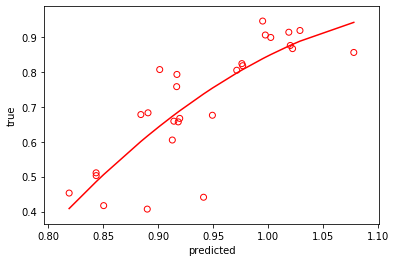

In [22]:
train_data, test_data = train_test_split(model_df, test_size=0.3, random_state=0)

x = train_data['predicted'].values.reshape(-1,1)
y = train_data['true']

polynomial_features = PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_pred))
r2 = r2_score(y,y_pred)

plt.scatter(x,y,facecolors='none', edgecolors='r')
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_pred), key=sort_axis)
x, y_pred = zip(*sorted_zip)
plt.plot(x, y_pred, color='r')

plt.xlabel('predicted')
plt.ylabel('true')

print('r2:', round(r2,4), ' RMSE: ', round(rmse, 4))

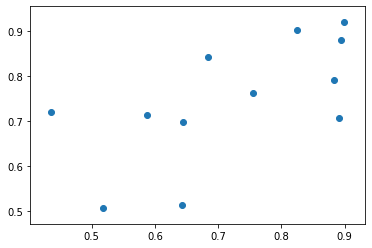

In [27]:
x = test_data['predicted'].values.reshape(-1,1)
x_poly = polynomial_features.fit_transform(x)
y_pred = model.predict(x_poly)
plt.scatter(y_pred,test_data['true'])

# Conclusion

While this was good practice on implementing my own model in a topic that I am interested in, I do not think that continuing this project will be anymore worthwhile. The main issue is the the gather that I have data used to predict is too different from data I am using as the predictive features. While the model was quite accurate, the transformation was based on the true value so I could not use this model in the future since I depended on the value that it was trying to predict. My model is unable to capture the true value as a result.

But I did learn many important lessons from this practice:
(1) Ensure the quality of the data.
The data that I have used came from very different sources and next time I will do a better way of documenting my sources and the validating of the data

(2) While not working on a server to keep this notebook online, constantly save and partition the notebook such that it is not always dependent on other variables.
Re-running the notebook is annoying each time and take awhile to run as the notebook got larger.

(3) Pre-plan before deploying.
I was just coming up with the next step along the way and could have been more effective if I had written out my objective beforehand.